In [1]:
# Check time stamps
# Inspect data and visualize the time stamps of the data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

tdf = pd.read_csv('data/Electric_Production.csv', parse_dates=["DATE"], index_col="DATE")

In [3]:
print(tdf.head())

            IPG2211A2N
DATE                  
1985-01-01     72.5052
1985-02-01     70.6720
1985-03-01     62.4502
1985-04-01     57.4714
1985-05-01     55.3151


In [4]:
# checking for missing values
tdf.isnull().sum()

IPG2211A2N    0
dtype: int64

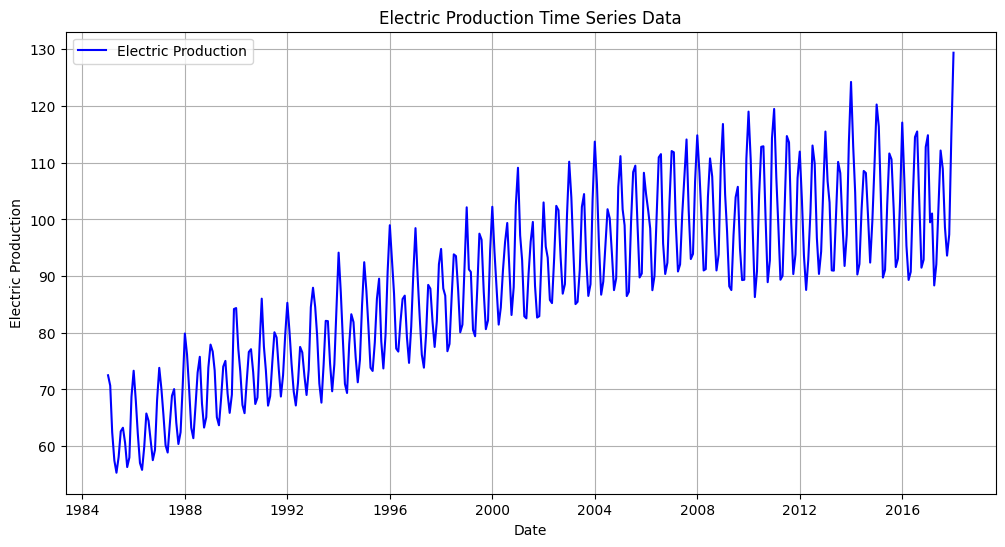

In [5]:
# plotting the TSD
plt.figure(figsize=(12, 6))
plt.plot(tdf.index, tdf["IPG2211A2N"], label="Electric Production", color="blue")
plt.title("Electric Production Time Series Data")
plt.xlabel("Date")
plt.ylabel("Electric Production")
plt.grid(True)
plt.legend()
plt.show()

In [6]:
tdf.index.duplicated().sum()  # check for duplicate timestamps

np.int64(0)

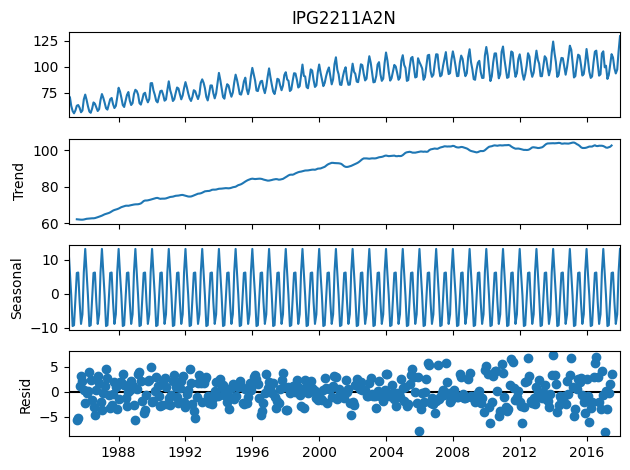

In [7]:
# EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose the time series data
result = seasonal_decompose(tdf["IPG2211A2N"], model='additive', period=12)



# Plot decomposition
result.plot()
plt.show() 

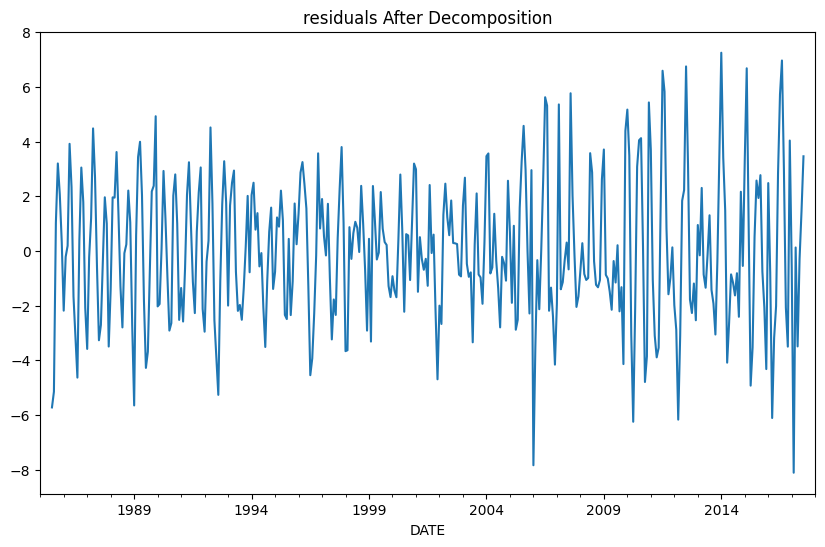

DATE
2006-01-01   -7.835856
2017-02-01   -8.109151
Name: resid, dtype: float64


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose


# Decompose 
result = seasonal_decompose(tdf["IPG2211A2N"], model='additive', period=12)
residual = result.resid

# Plot residuals
residual.plot(figsize=(10, 6))
plt.title("residuals After Decomposition")
plt.show()


# Detect large residuals
outliers = residual[np.abs(residual) > 3 * residual.std()]
print(outliers)

In [9]:
# checking if the data is stationary
from statsmodels.tsa.stattools import adfuller, kpss

result_adfuller = adfuller(tdf["IPG2211A2N"])
print("ADF Statistic:", result_adfuller[0])
print("p-value:", result_adfuller[1])


ADF Statistic: -2.25699035004725
p-value: 0.18621469116586592


In [10]:
result_kpss = kpss(tdf["IPG2211A2N"])
print("KPSS Statistic:", result_kpss[0])
print("p-value:", result_kpss[1])

KPSS Statistic: 3.5315970094994853
p-value: 0.01


C:\Users\admin\AppData\Local\Temp\ipykernel_22776\429482892.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result_kpss = kpss(tdf["IPG2211A2N"])


## Converting the non-stationary data to stationary

In [11]:
tdf.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


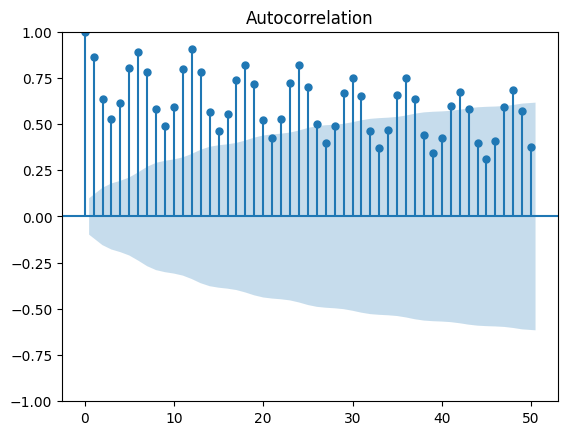

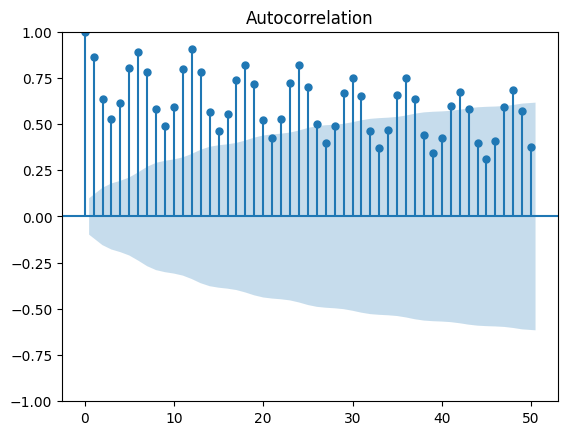

In [12]:
# subtracting the current value from the previous value
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tdf["IPG2211A2N"], lags=50)

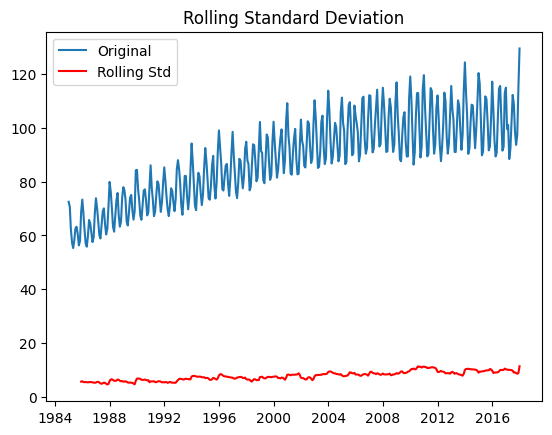

In [13]:
# checking for variance
rolling_std = tdf["IPG2211A2N"].rolling(window=12).std()
plt.plot(tdf["IPG2211A2N"], label='Original')
plt.plot(rolling_std, label='Rolling Std', color='red')
plt.legend()
plt.title("Rolling Standard Deviation")
plt.show()


In [14]:
# ARCH test
from statsmodels.stats.diagnostic import het_arch
arch_test = het_arch(tdf["IPG2211A2N"].dropna())
print("P-value: ", arch_test[1])

P-value:  2.423304983052259e-71


In [15]:
tdf_complement = tdf.copy()

In [16]:
tdf_complement["IPG2211A2N"] = np.log(tdf_complement["IPG2211A2N"])

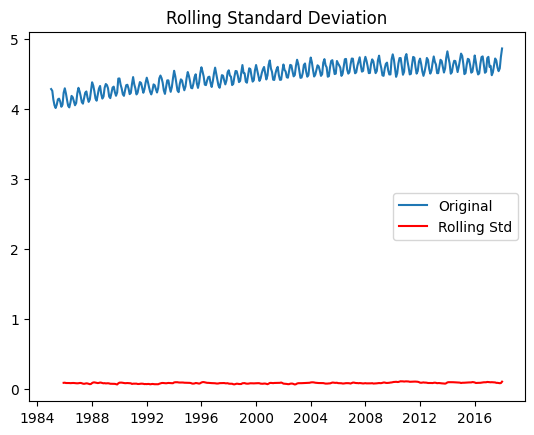

In [17]:
rolling_std = tdf_complement["IPG2211A2N"].rolling(window=12).std()
plt.plot(tdf_complement["IPG2211A2N"], label='Original')
plt.plot(rolling_std, label='Rolling Std', color='red')
plt.legend()
plt.title("Rolling Standard Deviation")
plt.show()

In [18]:
arch_test = het_arch(tdf_complement["IPG2211A2N"].dropna())
print("P-value: ", arch_test[1])

P-value:  5.1696768412511864e-73


In [19]:
from scipy import stats
tdf_complement["boxcox"], fitted_lambda = stats.boxcox(tdf_complement["IPG2211A2N"])

In [24]:
arch_test = het_arch(tdf_complement["boxcox"].dropna())
print("P-value: ", arch_test[1])

P-value:  5.6940349694431525e-71


In [22]:
tdf_complement.head()

,IPG2211A2N,boxcox
DATE,,
1985-01-01,4.283658,661.739371
1985-02-01,4.258049,639.668804
1985-03-01,4.134369,541.419533
1985-04-01,4.051287,482.676089
1985-05-01,4.013046,457.458911


In [25]:
from arch import arch_model

# Drop NaNs from transformation if needed
series = tdf_complement["boxcox"].dropna()


# Fit GARCH(1,1)
model = arch_model(series, vol='Garch', p=1, q=1)
res = model.fit(disp="off")
print(res.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 boxcox   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2598.49
Distribution:                  Normal   AIC:                           5204.98
Method:            Maximum Likelihood   BIC:                           5220.92
                                        No. Observations:                  397
Date:                Tue, May 13 2025   Df Residuals:                      396
Time:                        13:35:05   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu           910.0762     23.619     38.532      0.000 [8.

c:\Users\admin\Documents\TSA\tsa0\Lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.494e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [26]:
def test_stationarity(timeseries):
    # Perform Augmented Dickey-Fuller test
    adf_result = adfuller(timeseries)
    print('ADF Statistic:', adf_result[0])
    print('p-value:', adf_result[1])
    if adf_result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

test_stationarity(tdf["IPG2211A2N"].dropna())

ADF Statistic: -2.25699035004725
p-value: 0.18621469116586592
The time series is not stationary


In [27]:
# removing the trend ---> using the difference method
tdf['diff'] = tdf['IPG2211A2N'].diff()
test_stationarity(tdf['diff'].dropna())

ADF Statistic: -7.104890882267312
p-value: 4.0777865655394095e-10
The time series is stationary


In [35]:
tdf_complement = tdf.copy()
tdf_complement = tdf.drop("IPG2211A2N", axis=1)

In [36]:
tdf_complement.head()

,diff
DATE,
1985-01-01,NaN
1985-02-01,-1.8332
1985-03-01,-8.2218
1985-04-01,-4.9788
1985-05-01,-2.1563


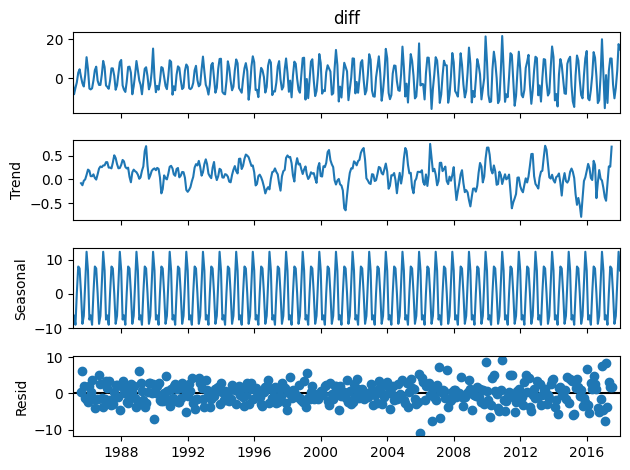

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose the time series data
result = seasonal_decompose(tdf_complement["diff"].dropna(), model='additive', period=12)
# Plot decomposition
result.plot()
plt.show()

In [37]:
tdf_complement.isnull().sum()

diff    1
dtype: int64

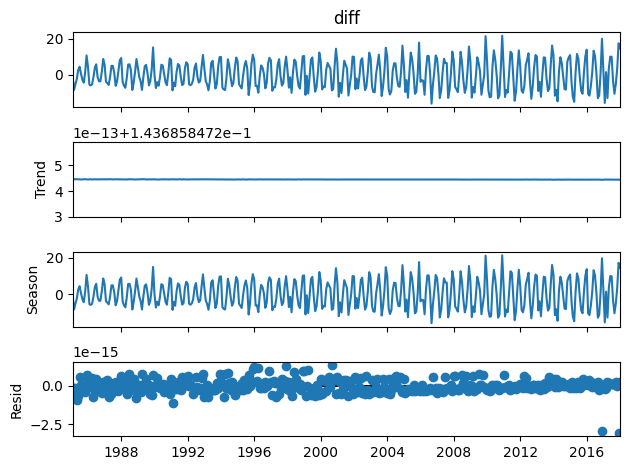

In [56]:
from statsmodels.tsa.seasonal import STL

stl = STL(tdf_complement["diff"].dropna(), period=397)
result = stl.fit()

result.plot()
plt.show()

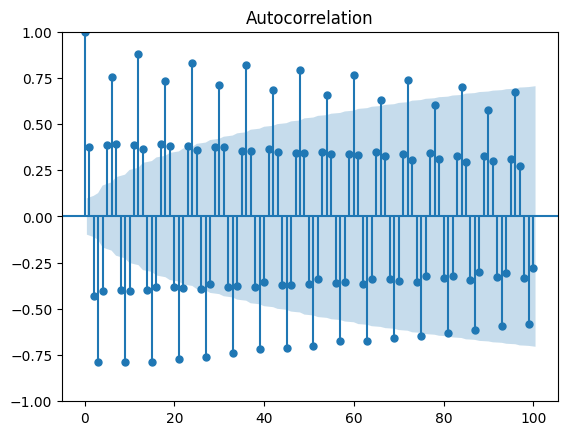

In [47]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(tdf_complement["diff"].dropna(), lags=100)
plt.show()

In [55]:
tdf_complement.isnull().sum()

diff    1
dtype: int64

In [54]:
tdf_complement.head()

,diff
DATE,
1985-01-01,NaN
1985-02-01,-1.8332
1985-03-01,-8.2218
1985-04-01,-4.9788
1985-05-01,-2.1563


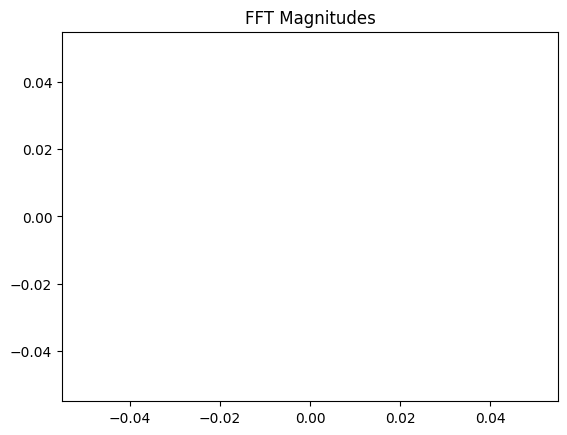

In [53]:
fft_vals = np.fft.fft(tdf_complement["diff"] - tdf_complement["diff"].mean())
plt.plot(np.abs(fft_vals))
plt.title("FFT Magnitudes")
plt.show()

In [57]:
# using fourier transofmers to  check seasonality

signal = tdf_complement["diff"].dropna().values
signal_centered = signal - np.mean(signal)

# step 2: Apply FFT
fft_vals = np.fft.fft(signal_centered)
fft_freq =  np.fft.fftfreq(len(signal_centered))

# step 3: Take only the positive frequencies
positive_freqs = fft_freq[:len(fft_freq) // 2]
magnitude = np.abs(fft_vals)[:len(fft_vals) // 2]

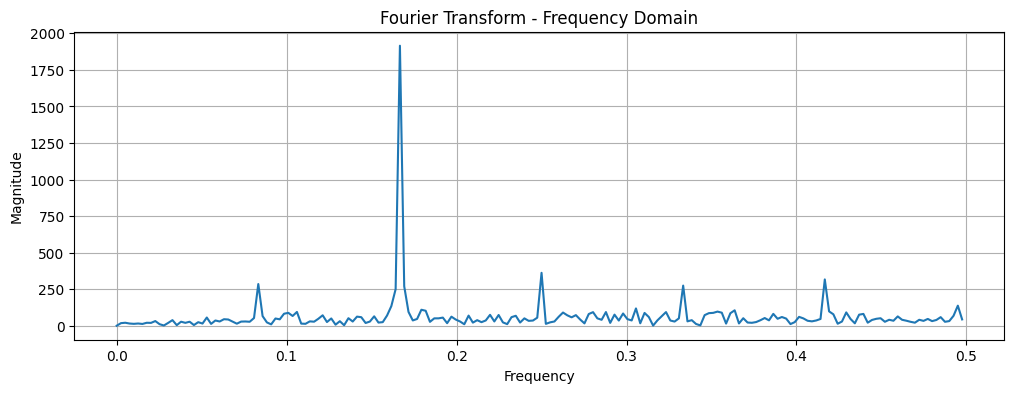

In [58]:
# Step 4: Plot
plt.figure(figsize=(12, 4))
plt.plot(positive_freqs, magnitude)
plt.title("Fourier Transform - Frequency Domain")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()